# Càlcul de les mètriques

In [27]:
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import os
import pandas as pd
import seaborn as sns

## Selecconar df inicial. Conjun de test o validació

In [57]:
#df = pd.read_excel('Resultats/resultats_1_test.xlsx', engine='openpyxl')
df = pd.read_excel('Resultats/resultats_1_valid.xlsx', engine='openpyxl')

In [58]:
#convert label to binary
# Function to convert 'DR' to 1 and 'No_DR' to 0
convert_to_binary = lambda x: 1 if x == 'DR' else 0
df['True Label'] = df['True Label'].apply(convert_to_binary)
df['Predicted Label'] = df['Predicted Label'].apply(convert_to_binary)
df

,Image,True Label,Predicted Label,Confidence
0,valid_001.jpg,1,1,88.750000
1,valid_002.jpg,1,1,89.860000
2,valid_003.jpg,1,1,87.810000
3,valid_004.jpg,1,1,85.320000
4,valid_005.jpg,1,1,79.220000
...,...,...,...,...
526,valid_527.jpg,0,0,87.115008
527,valid_528.jpg,0,1,52.209032
528,valid_529.jpg,0,0,88.951051
529,valid_530.jpg,0,0,71.863514


In [59]:
#Insert column 0 and 1 according of correctness of prediction
df.insert(3, 'Correct', (df['True Label'] == df['Predicted Label']).astype(int))
#Round confidence to 2 decimals
df['Confidence'] = df['Confidence'].round(2)
df

,Image,True Label,Predicted Label,Correct,Confidence
0,valid_001.jpg,1,1,1,88.75
1,valid_002.jpg,1,1,1,89.86
2,valid_003.jpg,1,1,1,87.81
3,valid_004.jpg,1,1,1,85.32
4,valid_005.jpg,1,1,1,79.22
...,...,...,...,...,...
526,valid_527.jpg,0,0,1,87.12
527,valid_528.jpg,0,1,0,52.21
528,valid_529.jpg,0,0,1,88.95
529,valid_530.jpg,0,0,1,71.86


### Calcular score dels mapes d'atenció

Total Attention Score (normalizaded): 0.05805564413265306
Tortuous vessels Attention Score (normalized): 0.13020833333333334
Attention Score Ratio of tortuous vessel pattern vs total image: 2.24


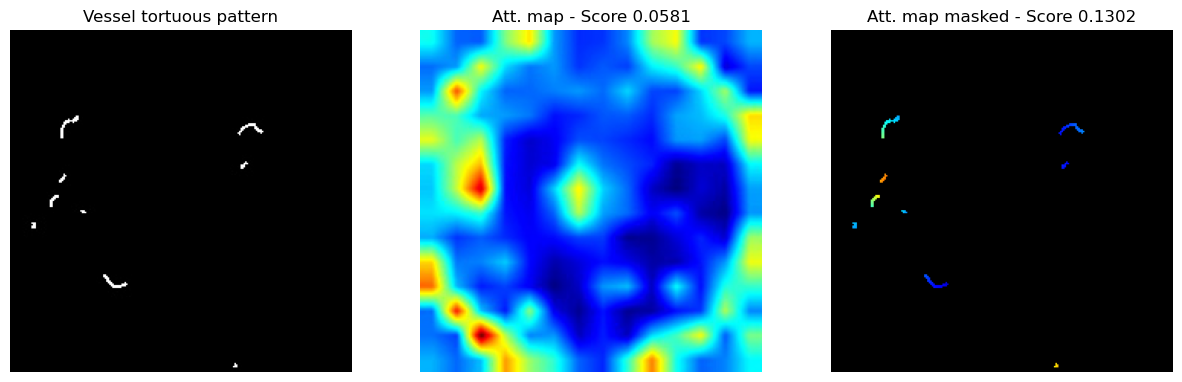

In [8]:
#Compute the avg attention score applying vessel pattern as a mask 
def attention_score_masked(img_path, mask_path=None):
    img = Image.open(img_path)
    img_array = np.array(img)
    red_channel_img = img_array[:,:,0]  # Extraemos el canal rojo
    
    #Define red channel treshold
    threshold = 200   
    
    if mask_path:
        #If we provide a mask we apply
        mask = Image.open(mask_path)
        mask_array = np.array(mask)
        mask_threshold = 128  # Asumimos que la máscara es binaria
        # Apply mask to red channel
        masked_red_channel = np.where(mask_array > mask_threshold, red_channel_img, 0)
        # Compute score using pixels from mask
        score = np.sum(masked_red_channel > threshold)
        #Normalize by number of pixels in the mask
        relevant_pixels = np.sum(mask_array > mask_threshold)
    else:
        #Without mask we score all image
        score = np.sum(red_channel_img > threshold)
        # Normalize by total number of pixels in the image
        relevant_pixels = img_array.shape[0] * img_array.shape[1]

    #Return normalized score
    normalized_score = score / relevant_pixels
    
    return normalized_score

#using the function
attention_map_path = "Dataset/test_1_map/DR/test_001.jpg"
tortuous_pattern_mask_path = "Dataset/test_tortuosity_binarized/DR/test_001.jpg"  

normalized_total_score = attention_score_masked(attention_map_path)
print("Total Attention Score (normalizaded):", normalized_total_score)

if tortuous_pattern_mask_path:
    normalized_tortuous_score = attention_score_masked(attention_map_path, tortuous_pattern_mask_path)
    print("Tortuous vessels Attention Score (normalized):", normalized_tortuous_score)
    print(f'Attention Score Ratio of tortuous vessel pattern vs total image: {(normalized_tortuous_score/normalized_total_score):.2f}')

img1=Image.open(tortuous_pattern_mask_path)
score1= attention_score_masked(attention_map_path, tortuous_pattern_mask_path)

img2=Image.open(attention_map_path)
score2= attention_score_masked(attention_map_path)

mask_array= np.array(img1)
mask_array_3d = np.stack([mask_array]*3, axis=-1)
attention_map_array= np.array(img2)

zero_array = np.zeros_like(attention_map_array)

img3 = np.where(mask_array_3d > 128, attention_map_array, zero_array)


fig, (ax1,ax2, ax3)=plt.subplots(ncols=3, figsize=(15,10))

ax1.imshow(img1, cmap='gray')
ax1.set_title(f'Vessel tortuous pattern')
ax1.axis('off')
ax2.imshow(img2)
ax2.set_title(f'Att. map - Score {score2:.4f}')
ax2.axis('off')
ax3.imshow(img3)
ax3.set_title(f'Att. map masked - Score {score1:.4f}')
ax3.axis('off')
plt.show()


In [61]:
#Add colums to df to store new values
df['Tort Score All Tf']= 0.0
df['Tort Score Tf11']= 0.0
df

,Image,True Label,Predicted Label,Correct,Confidence,Tort Score All Tf,Tort Score Tf11
0,valid_001.jpg,1,1,1,88.75,0.0,0.0
1,valid_002.jpg,1,1,1,89.86,0.0,0.0
2,valid_003.jpg,1,1,1,87.81,0.0,0.0
3,valid_004.jpg,1,1,1,85.32,0.0,0.0
4,valid_005.jpg,1,1,1,79.22,0.0,0.0
...,...,...,...,...,...,...,...
526,valid_527.jpg,0,0,1,87.12,0.0,0.0
527,valid_528.jpg,0,1,0,52.21,0.0,0.0
528,valid_529.jpg,0,0,1,88.95,0.0,0.0
529,valid_530.jpg,0,0,1,71.86,0.0,0.0


In [63]:
#Calculate for every image and add to df 
#executar per DR y per No_DR

#att_map_folder_alltf = 'Dataset/test_1_map/DR'
#att_map_folder_tf11 = 'Dataset/test_1_map_b11/DR'
#vessel_folder = 'Dataset/test_tortuosity_binarized/DR'

att_map_folder_alltf='Dataset/valid_1_map/No_DR'
att_map_folder_tf11='Dataset/valid_1_map_b11/No_DR'
vessel_folder = 'Dataset/valid_tortuosity_binarized/No_DR'

images = os.listdir(att_map_folder_alltf)
for image in images:
    attention_map_path_alltf = os.path.join(att_map_folder_alltf, image)
    attention_map_path_tf11 = os.path.join(att_map_folder_tf11, image)
    tortuous_pattern_mask_path =os.path.join(vessel_folder, image)
    normalized_total_score_alltf = attention_score_masked(attention_map_path_alltf)
    normalized_total_score_tf11 = attention_score_masked(attention_map_path_tf11)
    normalized_tortuous_score_alltf = attention_score_masked(attention_map_path_alltf, tortuous_pattern_mask_path)
    normalized_tortuous_score_tf11 = attention_score_masked(attention_map_path_tf11, tortuous_pattern_mask_path)
    ratio_alltf=normalized_tortuous_score_alltf/normalized_total_score_alltf
    ratio_tf11=normalized_tortuous_score_tf11/normalized_total_score_tf11

    df.loc[df['Image'] == image, 'Tort Score All Tf'] = round(ratio_alltf,2)
    df.loc[df['Image'] == image, 'Tort Score Tf11'] = round(ratio_tf11,2)
    print(f'Attention score for {image}: {ratio_alltf} - {ratio_tf11}')

 


Attention score for valid_246.jpg: 0.8282352941176471 - 0.0
Attention score for valid_247.jpg: 0.5289634848952893 - 1.857323783159225
Attention score for valid_248.jpg: 3.8086494660126786 - 0.5843285450596545
Attention score for valid_249.jpg: 0.760808391460462 - 0.0
Attention score for valid_250.jpg: 0.5787234379103792 - 0.0
Attention score for valid_251.jpg: 1.1582518706043117 - 0.0
Attention score for valid_252.jpg: 0.5603014121435862 - 0.0
Attention score for valid_253.jpg: 2.1060054060406626 - 0.9769698668972017
Attention score for valid_254.jpg: 0.0 - 0.0
Attention score for valid_255.jpg: 0.7153433597798587 - 0.0
Attention score for valid_256.jpg: 1.5242870122162182 - 0.0
Attention score for valid_257.jpg: 0.4759622944533648 - 0.0
Attention score for valid_258.jpg: 1.2159633970201917 - 0.0
Attention score for valid_259.jpg: 0.6983200138555559 - 0.0
Attention score for valid_260.jpg: 2.0876243105554506 - 0.0
Attention score for valid_261.jpg: 2.0437660212312996 - 0.0
Attention sc

Attention score for valid_386.jpg: 0.3576598144981861 - 0.0
Attention score for valid_387.jpg: 1.846790354418391 - 0.0
Attention score for valid_388.jpg: 0.45617750007231916 - 0.0
Attention score for valid_389.jpg: 9.195222008787619 - 0.0
Attention score for valid_390.jpg: 0.7492631391466966 - 0.0
Attention score for valid_391.jpg: 0.8738552951722371 - 0.0
Attention score for valid_392.jpg: 1.044085728418991 - 0.0
Attention score for valid_393.jpg: 3.078956097172653 - 0.13139481292160723
Attention score for valid_394.jpg: 5.7414141414141415 - 0.0
Attention score for valid_395.jpg: 2.2399000044640864 - 0.0
Attention score for valid_396.jpg: 1.2612316715542522 - 0.0
Attention score for valid_397.jpg: 1.7907311118831073 - 0.0
Attention score for valid_398.jpg: 0.7611297436201119 - 0.40078341911964394
Attention score for valid_399.jpg: 1.5536803652968036 - 0.0
Attention score for valid_400.jpg: 1.0248967069592105 - 0.0
Attention score for valid_401.jpg: 1.2484302336101913 - 0.8312211542603

Attention score for valid_529.jpg: 0.7124153529036417 - 0.0
Attention score for valid_530.jpg: 0.7278428314385863 - 0.0
Attention score for valid_531.jpg: 1.015773860521679 - 2.956358265073184


In [64]:
df

,Image,True Label,Predicted Label,Correct,Confidence,Tort Score All Tf,Tort Score Tf11
0,valid_001.jpg,1,1,1,88.75,1.46,0.00
1,valid_002.jpg,1,1,1,89.86,0.00,0.00
2,valid_003.jpg,1,1,1,87.81,2.11,0.00
3,valid_004.jpg,1,1,1,85.32,0.81,0.00
4,valid_005.jpg,1,1,1,79.22,0.98,0.00
...,...,...,...,...,...,...,...
526,valid_527.jpg,0,0,1,87.12,1.09,0.99
527,valid_528.jpg,0,1,0,52.21,2.74,0.00
528,valid_529.jpg,0,0,1,88.95,0.71,0.00
529,valid_530.jpg,0,0,1,71.86,0.73,0.00


In [65]:
#df.to_excel('Resultats/resultats_2_test.xlsx', index=False)
df.to_excel('Resultats/resultats_2_valid.xlsx', index=False)

In [27]:
df = pd.read_excel('Resultats/resultats_2_valid.xlsx', engine='openpyxl')

## Calcular la cobertura de la tortuositat amb el mapa d'atenció general i afegir-lo al dataframe

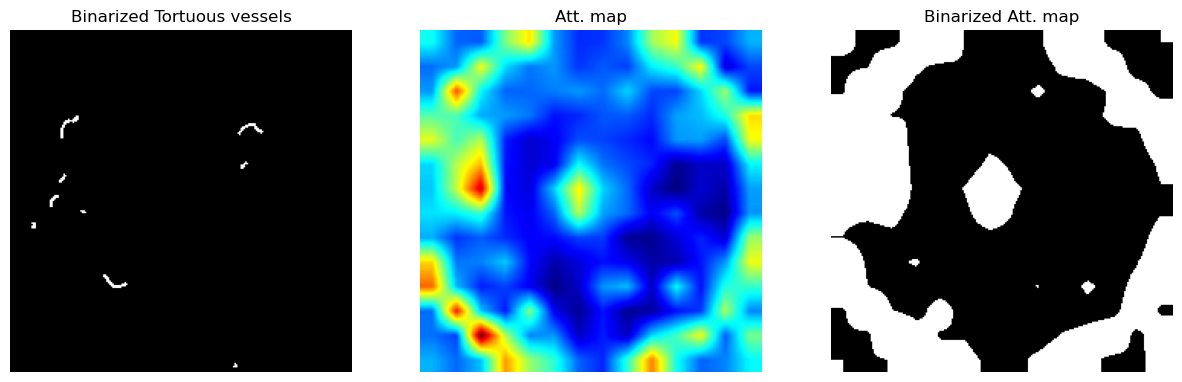

Tortuosity coverage: 45.83


In [28]:
#Function to compute which % of tortuosity is covered by the attention map
def tortuosity_coverage(binary_vessels, binary_attention_map):
    #Intersection: white pixels in both images
    intersection = np.logical_and(binary_vessels, binary_attention_map)
    #White pixels in tortuous vessels
    total_vessel_pixels = np.sum(binary_vessels)
    
    #If no white pixels in tortuous vessel, cover can not be computed
    if total_vessel_pixels == 0:
        return 0
    
    #% of tortuus vessels pixels inside attention map
    coverage = np.sum(intersection) / total_vessel_pixels
    return round(coverage * 100, 2)

#Using function
#Load tortuous vessels binarized image
tortuous_vessels_path = 'Dataset/test_tortuosity_binarized/DR/test_001.jpg'
vessels = cv2.imread(tortuous_vessels_path, cv2.IMREAD_UNCHANGED)

#Load a binarized attention map 
att_map_path = 'Dataset/test_1_map_binarized/DR/test_001.jpg'
attention = cv2.imread(att_map_path, cv2.IMREAD_UNCHANGED)

att_map_orig_path= 'Dataset/test_1_map/DR/test_001.jpg'
attention_orig =Image.open(att_map_orig_path)


# Convert images to numpy arrays and binarize 
vessels_binary = np.array(vessels) > 128
attention_binary = np.array(attention) > 128

# Visualize binarized tortuous vessels
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,10))

ax1.set_title('Binarized Tortuous vessels')
ax1.axis('off')
ax1.imshow(vessels_binary, cmap='gray')

# Visualize binarized attention map
ax3.set_title('Binarized Att. map')
ax3.axis('off')
ax3.imshow(attention_binary, cmap='gray')

ax2.imshow(attention_orig)
ax2.set_title('Att. map')
ax2.axis('off')
plt.show()

#Compute coverage
score = tortuosity_coverage(vessels_binary, attention_binary)
print(f'Tortuosity coverage: {score}')



In [67]:
#Add column to df to store new values
df['Tort. coverage All Tf. Blocks']=0.0

In [71]:
#executar per DR y per No_DR
#tortuous_vessels_folder = 'Dataset/test_tortuosity_binarized/DR'
#att_maps_folder= 'Dataset/test_1_map_binarized/DR'

tortuous_vessels_folder = 'Dataset/valid_tortuosity_binarized/DR'
att_maps_folder= 'Dataset/valid_1_map_binarized/DR'

images = os.listdir(tortuous_vessels_folder)
for image in images:
    imgpath_vessels = os.path.join(tortuous_vessels_folder, image) 
    imgpath_map= os.path.join(att_maps_folder, image) 
    vessels = cv2.imread(imgpath_vessels, cv2.IMREAD_UNCHANGED)
    vessels_binary = np.array(vessels) > 128 #assegurem binarització
    attention = cv2.imread(imgpath_map, cv2.IMREAD_UNCHANGED)
    attention_binary = np.array(attention) >128
    score = tortuosity_coverage(vessels_binary, attention_binary)
    df.loc[df['Image'] == image, 'Tort. coverage All Tf. Blocks'] = score
  

In [72]:
df

,Image,True Label,Predicted Label,Correct,Confidence,Tort Score All Tf,Tort Score Tf11,Tort. coverage All Tf. Blocks
0,valid_001.jpg,1,1,1,88.75,1.46,0.00,44.73
1,valid_002.jpg,1,1,1,89.86,0.00,0.00,16.00
2,valid_003.jpg,1,1,1,87.81,2.11,0.00,52.96
3,valid_004.jpg,1,1,1,85.32,0.81,0.00,46.28
4,valid_005.jpg,1,1,1,79.22,0.98,0.00,61.33
...,...,...,...,...,...,...,...,...
526,valid_527.jpg,0,0,1,87.12,1.09,0.99,47.83
527,valid_528.jpg,0,1,0,52.21,2.74,0.00,44.53
528,valid_529.jpg,0,0,1,88.95,0.71,0.00,55.56
529,valid_530.jpg,0,0,1,71.86,0.73,0.00,54.50


In [73]:
#df.to_excel('Resultats/resultats_3_test.xlsx', index=False)
df.to_excel('Resultats/resultats_3_valid.xlsx', index=False)

## Calcular la cobertura de la tortuositat amb els 12 mapes d'atenció i afegir-les al dataframe

In [74]:
#New columns
for i in range(12):
    df[f'Tort. coverage Tf. Block_{i}'] = 0.0


In [76]:
#executar per DR y per No_DR
#tortuous_vessels_folder = 'Dataset/test_tortuosity_binarized/No_DR'
#att_maps_folder= 'Dataset/test_12_maps_binarized/No_DR'

tortuous_vessels_folder = 'Dataset/valid_tortuosity_binarized/DR'
att_maps_folder= 'Dataset/valid_12_maps_binarized/DR'

count=0
images = os.listdir(tortuous_vessels_folder)
for image in images:
    image_name_without_extension = os.path.splitext(image)[0]
    imgpath_vessels = os.path.join(tortuous_vessels_folder, image)
    vessels = cv2.imread(imgpath_vessels, cv2.IMREAD_UNCHANGED)
    vessels_binary = np.array(vessels) > 128 #assegurem binarització
    #print(imgpath_vessels)

    # Esta es la carpeta que contiene los 12 mapas para la imagen actual
    maps_folder_path = os.path.join(att_maps_folder, image_name_without_extension)
    #print(f'Carpeta: {maps_folder_path}')
  
    # Comprobamos si la carpeta existe antes de intentar listar su contenido
    if os.path.isdir(maps_folder_path):
        maps = os.listdir(maps_folder_path)
        
        for map_path_rel in maps:  # Este debería ser el nombre de los archivos de mapa, no "folder"
           
            map_path= os.path.join(maps_folder_path, map_path_rel) #ruta absoluta del mapa
            attention = cv2.imread(map_path, cv2.IMREAD_UNCHANGED)
            attention_binary = np.array(attention) >128
            score = tortuosity_coverage(vessels_binary, attention_binary) 
            #extreure l'index del Att. Block 
            block_index = int(map_path_rel.split('_')[-1].split('.')[0])
            # Trobar la fila del DataFrame on la columna 'Image' coincideix amb 'image_name_without_extension'
            row_index = df.index[df['Image'] == f'{image_name_without_extension}.jpg'].tolist()[0]
            # Colocar el valor de 'score' a la columna correcte del DataFrame
            df.at[row_index, f'Tort. coverage Tf. Block_{block_index}'] = score
            #print(f'{map_path_rel} - {block_index} - {row_index}')
            
            
    else:
        print("No existe la carpeta para la imagen:", image_name_without_extension)



In [77]:
df

,Image,True Label,Predicted Label,Correct,Confidence,Tort Score All Tf,Tort Score Tf11,Tort. coverage All Tf. Blocks,Tort. coverage Tf. Block_0,Tort. coverage Tf. Block_1,Tort. coverage Tf. Block_2,Tort. coverage Tf. Block_3,Tort. coverage Tf. Block_4,Tort. coverage Tf. Block_5,Tort. coverage Tf. Block_6,Tort. coverage Tf. Block_7,Tort. coverage Tf. Block_8,Tort. coverage Tf. Block_9,Tort. coverage Tf. Block_10,Tort. coverage Tf. Block_11
0,valid_001.jpg,1,1,1,88.75,1.46,0.00,44.73,36.76,28.02,33.93,76.61,21.59,24.16,0.00,0.00,0.00,0.00,0.00,30.08
1,valid_002.jpg,1,1,1,89.86,0.00,0.00,16.00,100.00,100.00,100.00,16.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,valid_003.jpg,1,1,1,87.81,2.11,0.00,52.96,13.11,6.68,53.73,83.80,40.62,21.34,1.03,1.54,1.54,1.29,0.51,13.37
3,valid_004.jpg,1,1,1,85.32,0.81,0.00,46.28,28.49,12.34,49.36,71.14,59.89,29.40,0.00,0.00,0.00,0.00,0.00,9.07
4,valid_005.jpg,1,1,1,79.22,0.98,0.00,61.33,60.22,45.30,52.21,58.01,29.83,15.75,0.00,0.00,0.00,0.00,0.00,22.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,valid_527.jpg,0,0,1,87.12,1.09,0.99,47.83,49.83,57.83,56.00,20.00,6.00,7.67,5.50,5.83,5.83,5.83,5.50,8.33
527,valid_528.jpg,0,1,0,52.21,2.74,0.00,44.53,57.54,50.59,27.51,32.25,26.63,20.27,3.40,3.55,4.14,4.44,4.44,3.85
528,valid_529.jpg,0,0,1,88.95,0.71,0.00,55.56,48.38,40.65,51.05,47.26,30.38,18.85,1.55,1.83,1.41,1.41,1.13,1.55
529,valid_530.jpg,0,0,1,71.86,0.73,0.00,54.50,44.46,40.29,41.20,46.54,30.25,21.12,2.35,2.35,2.35,2.35,2.35,2.35


In [78]:
#df.to_excel('Resultats/resultats_4_test.xlsx', index=False)
df.to_excel('Resultats/resultats_4_valid.xlsx', index=False)

## Afegir mètriques gradcam 

### Tortuos score

In [17]:
#carregar ultim dataset fer afegir les metriques del gradcam
#df = pd.read_excel('Resultats/resultats_4_test.xlsx', engine='openpyxl')
df = pd.read_excel('Resultats/resultats_4_valid.xlsx', engine='openpyxl')

In [18]:
#Add colums to df to store new values
df['Tort Score GC']= 0.0
df

,Image,True Label,Predicted Label,Correct,Confidence,Tort Score All Tf,Tort Score Tf11,Tort. coverage All Tf. Blocks,Tort. coverage Tf. Block_0,Tort. coverage Tf. Block_1,...,Tort. coverage Tf. Block_3,Tort. coverage Tf. Block_4,Tort. coverage Tf. Block_5,Tort. coverage Tf. Block_6,Tort. coverage Tf. Block_7,Tort. coverage Tf. Block_8,Tort. coverage Tf. Block_9,Tort. coverage Tf. Block_10,Tort. coverage Tf. Block_11,Tort Score GC
0,valid_001.jpg,1,1,1,88.75,1.46,0.00,44.73,36.76,28.02,...,76.61,21.59,24.16,0.00,0.00,0.00,0.00,0.00,30.08,0.0
1,valid_002.jpg,1,1,1,89.86,0.00,0.00,16.00,100.00,100.00,...,16.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
2,valid_003.jpg,1,1,1,87.81,2.11,0.00,52.96,13.11,6.68,...,83.80,40.62,21.34,1.03,1.54,1.54,1.29,0.51,13.37,0.0
3,valid_004.jpg,1,1,1,85.32,0.81,0.00,46.28,28.49,12.34,...,71.14,59.89,29.40,0.00,0.00,0.00,0.00,0.00,9.07,0.0
4,valid_005.jpg,1,1,1,79.22,0.98,0.00,61.33,60.22,45.30,...,58.01,29.83,15.75,0.00,0.00,0.00,0.00,0.00,22.93,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,valid_527.jpg,0,0,1,87.12,1.09,0.99,47.83,49.83,57.83,...,20.00,6.00,7.67,5.50,5.83,5.83,5.83,5.50,8.33,0.0
527,valid_528.jpg,0,1,0,52.21,2.74,0.00,44.53,57.54,50.59,...,32.25,26.63,20.27,3.40,3.55,4.14,4.44,4.44,3.85,0.0
528,valid_529.jpg,0,0,1,88.95,0.71,0.00,55.56,48.38,40.65,...,47.26,30.38,18.85,1.55,1.83,1.41,1.41,1.13,1.55,0.0
529,valid_530.jpg,0,0,1,71.86,0.73,0.00,54.50,44.46,40.29,...,46.54,30.25,21.12,2.35,2.35,2.35,2.35,2.35,2.35,0.0


In [22]:
#Calculate for every image and add to df 
#executar per DR y per No_DR

gradcam_folder = 'Dataset/valid_gradcam/No_DR'
vessel_folder = 'Dataset/valid_tortuosity_binarized/No_DR'


#att_map_folder_tf11='Dataset/valid_1_map_b11/No_DR'
#vessel_folder = 'Dataset/valid_tortuosity_binarized/No_DR'

images = os.listdir(gradcam_folder)
for image in images:

    gradcam_path = os.path.join(gradcam_folder, image)
    tortuous_pattern_mask_path =os.path.join(vessel_folder, image)
   
    normalized_total_score_gradcam = attention_score_masked(gradcam_path)
  
    normalized_tortuous_score_gradcam = attention_score_masked(gradcam_path, tortuous_pattern_mask_path)

    ratio_gradcam=normalized_tortuous_score_gradcam/normalized_total_score_gradcam

    df.loc[df['Image'] == image, 'Tort Score GC'] = round(ratio_gradcam,2)
    print(f'Attention score for {image}: {ratio_gradcam}')

Attention score for valid_246.jpg: 3.83489032470472
Attention score for valid_247.jpg: 2.603265297111128
Attention score for valid_248.jpg: 0.2321529203723256
Attention score for valid_249.jpg: 1.212955852124184
Attention score for valid_250.jpg: 2.3346819187038594
Attention score for valid_251.jpg: 0.33916536569826633
Attention score for valid_252.jpg: 2.3267721140852156
Attention score for valid_253.jpg: 0.2244172758723251
Attention score for valid_254.jpg: 1.722630715748668
Attention score for valid_255.jpg: 0.9992854280700105
Attention score for valid_256.jpg: 0.0
Attention score for valid_257.jpg: 10.291943516809212
Attention score for valid_258.jpg: 1.1050293801470314
Attention score for valid_259.jpg: 3.11324583558404
Attention score for valid_260.jpg: 2.023556397871453
Attention score for valid_261.jpg: 1.6943617327826337
Attention score for valid_262.jpg: 1.532235729998842
Attention score for valid_263.jpg: 1.6995250964978512
Attention score for valid_264.jpg: 1.34474620846848

Attention score for valid_408.jpg: 3.042462391360841
Attention score for valid_409.jpg: 1.0478241546411073
Attention score for valid_410.jpg: 0.1407902955260584
Attention score for valid_411.jpg: 3.34600589639197
Attention score for valid_412.jpg: 1.232073217465792
Attention score for valid_413.jpg: 0.0
Attention score for valid_414.jpg: 0.9065098764096867
Attention score for valid_415.jpg: 0.8423460225567352
Attention score for valid_416.jpg: 2.012407954475137
Attention score for valid_417.jpg: 1.4220900884160976
Attention score for valid_418.jpg: 0.7861245694182121
Attention score for valid_419.jpg: 0.0
Attention score for valid_420.jpg: 0.05819369444599083
Attention score for valid_421.jpg: 2.774514754549893
Attention score for valid_422.jpg: 0.668712412747597
Attention score for valid_423.jpg: 1.2353135594020603
Attention score for valid_424.jpg: 6.577050497362551
Attention score for valid_425.jpg: 0.27624235069111575
Attention score for valid_426.jpg: 1.7306117887030752
Attention 

C:\Users\carle\AppData\Local\Temp\ipykernel_7260\1112666399.py:21: RuntimeWarning: invalid value encountered in scalar divide
  ratio_gradcam=normalized_tortuous_score_gradcam/normalized_total_score_gradcam


Attention score for valid_460.jpg: 0.26106445054637734
Attention score for valid_461.jpg: 0.433443521728614
Attention score for valid_462.jpg: 2.534260089581965
Attention score for valid_463.jpg: 0.0
Attention score for valid_464.jpg: 1.9855446711995641
Attention score for valid_465.jpg: 0.3469595059478081
Attention score for valid_466.jpg: 0.5609531397913987
Attention score for valid_467.jpg: 2.1292697048778644
Attention score for valid_468.jpg: 2.80077650496568
Attention score for valid_469.jpg: 0.5997516869095817
Attention score for valid_470.jpg: 1.5713479532328567
Attention score for valid_471.jpg: 1.083939393939394
Attention score for valid_472.jpg: 2.5303013246009134
Attention score for valid_473.jpg: 0.9686262094314416
Attention score for valid_474.jpg: 0.0
Attention score for valid_475.jpg: 3.079812667644658
Attention score for valid_476.jpg: 0.651280384295879
Attention score for valid_477.jpg: 2.1821928715282657
Attention score for valid_478.jpg: 0.0
Attention score for valid

In [23]:
df

,Image,True Label,Predicted Label,Correct,Confidence,Tort Score All Tf,Tort Score Tf11,Tort. coverage All Tf. Blocks,Tort. coverage Tf. Block_0,Tort. coverage Tf. Block_1,...,Tort. coverage Tf. Block_3,Tort. coverage Tf. Block_4,Tort. coverage Tf. Block_5,Tort. coverage Tf. Block_6,Tort. coverage Tf. Block_7,Tort. coverage Tf. Block_8,Tort. coverage Tf. Block_9,Tort. coverage Tf. Block_10,Tort. coverage Tf. Block_11,Tort Score GC
0,valid_001.jpg,1,1,1,88.75,1.46,0.00,44.73,36.76,28.02,...,76.61,21.59,24.16,0.00,0.00,0.00,0.00,0.00,30.08,2.21
1,valid_002.jpg,1,1,1,89.86,0.00,0.00,16.00,100.00,100.00,...,16.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.94
2,valid_003.jpg,1,1,1,87.81,2.11,0.00,52.96,13.11,6.68,...,83.80,40.62,21.34,1.03,1.54,1.54,1.29,0.51,13.37,0.32
3,valid_004.jpg,1,1,1,85.32,0.81,0.00,46.28,28.49,12.34,...,71.14,59.89,29.40,0.00,0.00,0.00,0.00,0.00,9.07,0.98
4,valid_005.jpg,1,1,1,79.22,0.98,0.00,61.33,60.22,45.30,...,58.01,29.83,15.75,0.00,0.00,0.00,0.00,0.00,22.93,1.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,valid_527.jpg,0,0,1,87.12,1.09,0.99,47.83,49.83,57.83,...,20.00,6.00,7.67,5.50,5.83,5.83,5.83,5.50,8.33,0.78
527,valid_528.jpg,0,1,0,52.21,2.74,0.00,44.53,57.54,50.59,...,32.25,26.63,20.27,3.40,3.55,4.14,4.44,4.44,3.85,0.00
528,valid_529.jpg,0,0,1,88.95,0.71,0.00,55.56,48.38,40.65,...,47.26,30.38,18.85,1.55,1.83,1.41,1.41,1.13,1.55,0.32
529,valid_530.jpg,0,0,1,71.86,0.73,0.00,54.50,44.46,40.29,...,46.54,30.25,21.12,2.35,2.35,2.35,2.35,2.35,2.35,0.49


In [24]:
#df.to_excel('Resultats/resultats_4_test.xlsx', index=False)
df.to_excel('Resultats/resultats_4_valid.xlsx', index=False)

### Attention coverage

In [54]:
#carregar ultim dataset fer afegir les metriques del gradcam
#df = pd.read_excel('Resultats/resultats_4_test.xlsx', engine='openpyxl')
df = pd.read_excel('Resultats/resultats_4_valid.xlsx', engine='openpyxl')

In [55]:
df

,Image,True Label,Predicted Label,Correct,Confidence,Tort Score All Tf,Tort Score Tf11,Tort. coverage All Tf. Blocks,Tort. coverage Tf. Block_0,Tort. coverage Tf. Block_1,...,Tort. coverage Tf. Block_3,Tort. coverage Tf. Block_4,Tort. coverage Tf. Block_5,Tort. coverage Tf. Block_6,Tort. coverage Tf. Block_7,Tort. coverage Tf. Block_8,Tort. coverage Tf. Block_9,Tort. coverage Tf. Block_10,Tort. coverage Tf. Block_11,Tort Score GC
0,valid_001.jpg,1,1,1,88.75,1.46,0.00,44.73,36.76,28.02,...,76.61,21.59,24.16,0.00,0.00,0.00,0.00,0.00,30.08,2.21
1,valid_002.jpg,1,1,1,89.86,0.00,0.00,16.00,100.00,100.00,...,16.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.94
2,valid_003.jpg,1,1,1,87.81,2.11,0.00,52.96,13.11,6.68,...,83.80,40.62,21.34,1.03,1.54,1.54,1.29,0.51,13.37,0.32
3,valid_004.jpg,1,1,1,85.32,0.81,0.00,46.28,28.49,12.34,...,71.14,59.89,29.40,0.00,0.00,0.00,0.00,0.00,9.07,0.98
4,valid_005.jpg,1,1,1,79.22,0.98,0.00,61.33,60.22,45.30,...,58.01,29.83,15.75,0.00,0.00,0.00,0.00,0.00,22.93,1.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,valid_527.jpg,0,0,1,87.12,1.09,0.99,47.83,49.83,57.83,...,20.00,6.00,7.67,5.50,5.83,5.83,5.83,5.50,8.33,0.78
527,valid_528.jpg,0,1,0,52.21,2.74,0.00,44.53,57.54,50.59,...,32.25,26.63,20.27,3.40,3.55,4.14,4.44,4.44,3.85,0.00
528,valid_529.jpg,0,0,1,88.95,0.71,0.00,55.56,48.38,40.65,...,47.26,30.38,18.85,1.55,1.83,1.41,1.41,1.13,1.55,0.32
529,valid_530.jpg,0,0,1,71.86,0.73,0.00,54.50,44.46,40.29,...,46.54,30.25,21.12,2.35,2.35,2.35,2.35,2.35,2.35,0.49


In [56]:
#Add colums to df to store new values
df['Tort. Coverage GC']= 0.0
df

,Image,True Label,Predicted Label,Correct,Confidence,Tort Score All Tf,Tort Score Tf11,Tort. coverage All Tf. Blocks,Tort. coverage Tf. Block_0,Tort. coverage Tf. Block_1,...,Tort. coverage Tf. Block_4,Tort. coverage Tf. Block_5,Tort. coverage Tf. Block_6,Tort. coverage Tf. Block_7,Tort. coverage Tf. Block_8,Tort. coverage Tf. Block_9,Tort. coverage Tf. Block_10,Tort. coverage Tf. Block_11,Tort Score GC,Tort. Coverage GC
0,valid_001.jpg,1,1,1,88.75,1.46,0.00,44.73,36.76,28.02,...,21.59,24.16,0.00,0.00,0.00,0.00,0.00,30.08,2.21,0.0
1,valid_002.jpg,1,1,1,89.86,0.00,0.00,16.00,100.00,100.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.94,0.0
2,valid_003.jpg,1,1,1,87.81,2.11,0.00,52.96,13.11,6.68,...,40.62,21.34,1.03,1.54,1.54,1.29,0.51,13.37,0.32,0.0
3,valid_004.jpg,1,1,1,85.32,0.81,0.00,46.28,28.49,12.34,...,59.89,29.40,0.00,0.00,0.00,0.00,0.00,9.07,0.98,0.0
4,valid_005.jpg,1,1,1,79.22,0.98,0.00,61.33,60.22,45.30,...,29.83,15.75,0.00,0.00,0.00,0.00,0.00,22.93,1.13,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,valid_527.jpg,0,0,1,87.12,1.09,0.99,47.83,49.83,57.83,...,6.00,7.67,5.50,5.83,5.83,5.83,5.50,8.33,0.78,0.0
527,valid_528.jpg,0,1,0,52.21,2.74,0.00,44.53,57.54,50.59,...,26.63,20.27,3.40,3.55,4.14,4.44,4.44,3.85,0.00,0.0
528,valid_529.jpg,0,0,1,88.95,0.71,0.00,55.56,48.38,40.65,...,30.38,18.85,1.55,1.83,1.41,1.41,1.13,1.55,0.32,0.0
529,valid_530.jpg,0,0,1,71.86,0.73,0.00,54.50,44.46,40.29,...,30.25,21.12,2.35,2.35,2.35,2.35,2.35,2.35,0.49,0.0


In [60]:
#executar per DR y per No_DR
#tortuous_vessels_folder = 'Dataset/test_tortuosity_binarized/No_DR'
#gradcam_folder= 'Dataset/test_gradcam_binarized/No_DR'

tortuous_vessels_folder = 'Dataset/valid_tortuosity_binarized/No_DR'
gradcam_folder= 'Dataset/valid_gradcam_binarized/No_DR'

images = os.listdir(tortuous_vessels_folder)
for image in images:
    imgpath_vessels = os.path.join(tortuous_vessels_folder, image) 
    imgpath_gradcam= os.path.join(gradcam_folder, image) 
    vessels = cv2.imread(imgpath_vessels, cv2.IMREAD_UNCHANGED)
    vessels_binary = np.array(vessels) > 128 #assegurem binarització
    gradcam = cv2.imread(imgpath_gradcam, cv2.IMREAD_UNCHANGED)
    gradcam_binary = np.array(gradcam) >128
    score = tortuosity_coverage(vessels_binary, gradcam_binary)
    df.loc[df['Image'] == image, 'Tort. Coverage GC'] = score

In [61]:
df

,Image,True Label,Predicted Label,Correct,Confidence,Tort Score All Tf,Tort Score Tf11,Tort. coverage All Tf. Blocks,Tort. coverage Tf. Block_0,Tort. coverage Tf. Block_1,...,Tort. coverage Tf. Block_4,Tort. coverage Tf. Block_5,Tort. coverage Tf. Block_6,Tort. coverage Tf. Block_7,Tort. coverage Tf. Block_8,Tort. coverage Tf. Block_9,Tort. coverage Tf. Block_10,Tort. coverage Tf. Block_11,Tort Score GC,Tort. Coverage GC
0,valid_001.jpg,1,1,1,88.75,1.46,0.00,44.73,36.76,28.02,...,21.59,24.16,0.00,0.00,0.00,0.00,0.00,30.08,2.21,77.38
1,valid_002.jpg,1,1,1,89.86,0.00,0.00,16.00,100.00,100.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.94,16.00
2,valid_003.jpg,1,1,1,87.81,2.11,0.00,52.96,13.11,6.68,...,40.62,21.34,1.03,1.54,1.54,1.29,0.51,13.37,0.32,91.77
3,valid_004.jpg,1,1,1,85.32,0.81,0.00,46.28,28.49,12.34,...,59.89,29.40,0.00,0.00,0.00,0.00,0.00,9.07,0.98,53.36
4,valid_005.jpg,1,1,1,79.22,0.98,0.00,61.33,60.22,45.30,...,29.83,15.75,0.00,0.00,0.00,0.00,0.00,22.93,1.13,100.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,valid_527.jpg,0,0,1,87.12,1.09,0.99,47.83,49.83,57.83,...,6.00,7.67,5.50,5.83,5.83,5.83,5.50,8.33,0.78,61.83
527,valid_528.jpg,0,1,0,52.21,2.74,0.00,44.53,57.54,50.59,...,26.63,20.27,3.40,3.55,4.14,4.44,4.44,3.85,0.00,49.41
528,valid_529.jpg,0,0,1,88.95,0.71,0.00,55.56,48.38,40.65,...,30.38,18.85,1.55,1.83,1.41,1.41,1.13,1.55,0.32,54.57
529,valid_530.jpg,0,0,1,71.86,0.73,0.00,54.50,44.46,40.29,...,30.25,21.12,2.35,2.35,2.35,2.35,2.35,2.35,0.49,32.99


In [62]:
#df.to_excel('Resultats/resultats_4_test.xlsx', index=False)
df.to_excel('Resultats/resultats_4_valid.xlsx', index=False)